##### Copyright 2020 The TensorFlow Quantum Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Binary classification of quantum states

Author : Antonio J. Martinez

Contributors : Masoud Mohseni

Created : 2020-Feb-14

Last updated : 2020-Feb-29

<a href="https://colab.research.google.com/github/tensorflow/quantum/blob/research/binary_classifier/binary_classifier.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

An elementary learning task is [binary classification](https://en.wikipedia.org/wiki/Binary_classification), a supervised task in which the learner is to distinguish which of two classes a given datapoint has been drawn from.  Here, using ideas from the paper [Universal discriminative quantum neural networks](https://arxiv.org/abs/1805.08654) in the one-qubit setting, we train a hybrid quantum-classical neural network to distinguish between quantum data sources.

## Import dependencies

In [ ]:
!pip install --upgrade cirq==0.7.0

In [ ]:
!pip install --upgrade tensorflow==2.1.0
!pip install qutip

In [ ]:
!pip install tensorflow-quantum

In [ ]:
import cirq
import numpy as np
import qutip
import random
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Quantum dataset
For our quantum dataset, you will generate two blobs on the surface of the Bloch sphere.  The task will be to learn a model to distinguish members of these blobs.  To do this, you first select two axes in the X-Z plane of the block sphere, then select random points uniformly distributed around them:

In [ ]:
def generate_dataset(qubit, theta_a, theta_b, num_samples):
  """Generate a dataset of points on `qubit` near the two given angles; labels
  for the two clusters use a one-hot encoding.
  """
  q_data = []
  bloch = {"a": [[], [], []], "b": [[], [], []]}
  labels = []
  blob_size = abs(theta_a - theta_b) / 5
  for _ in range(num_samples):
    coin = random.random()
    spread_x = np.random.uniform(-blob_size, blob_size)
    spread_y = np.random.uniform(-blob_size, blob_size)
    if coin < 0.5:
      label = [1, 0]
      angle = theta_a + spread_y
      source = "a"
    else:
      label = [0, 1]
      angle = theta_b + spread_y
      source = "b"
    labels.append(label)
    q_data.append(cirq.Circuit(cirq.ry(-angle)(qubit), cirq.rx(-spread_x)(qubit)))
    bloch[source][0].append(np.cos(angle))
    bloch[source][1].append(np.sin(angle)*np.sin(spread_x))
    bloch[source][2].append(np.sin(angle)*np.cos(spread_x))
  return tfq.convert_to_tensor(q_data), np.array(labels), bloch

Generate the dataset:

In [ ]:
qubit = cirq.GridQubit(0, 0)
theta_a = 1
theta_b = 4
num_samples = 200
q_data, labels, bloch_p = generate_dataset(qubit, theta_a, theta_b, num_samples)

View the data set on the Bloch sphere:

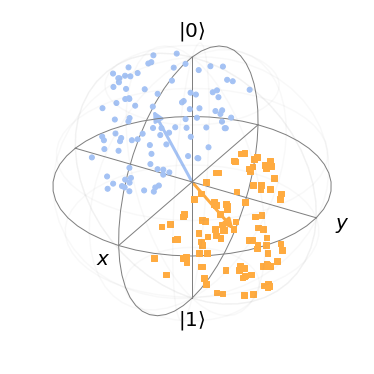

In [ ]:
bloch = qutip.Bloch()
bloch.sphere_alpha = 0.0
bloch.frame_alpha = 0.05
bloch.vector_color[0] = bloch.point_color[0] = "#a4c2f4ff"
bloch.vector_color[1] = bloch.point_color[1] = "#ffab40ff"
bloch.add_points(bloch_p["a"])
bloch.add_points(bloch_p["b"])
vec = [[np.cos(theta_a),0,np.sin(theta_a)]]
bloch.add_vectors(vec)
vec = [[np.cos(theta_b),0,np.sin(theta_b)]]
bloch.add_vectors(vec)
bloch.show()

## Model

We will use a parameterized rotation about the Y axis followed by a Z-axis measurement as the quantum portion of our model.  For the classical portion, we will use a two-unit SoftMax which should learn to distinguish the measurement statistics of the two datasources.  Finally, we compile the model with [standard optimizer settings](https://www.tensorflow.org/tutorials/keras/classification) for classification.  Note that the classical NN outputs represent the network's predicted probability that the given datapoint is a member of each category.

In [ ]:
# Build the quantum model layer
theta = sympy.Symbol('theta')
q_model = cirq.Circuit(cirq.ry(theta)(qubit))
q_data_input = tf.keras.Input(
    shape=(), dtype=tf.dtypes.string)
expectation = tfq.layers.PQC(q_model, cirq.Z(qubit))
expectation_output = expectation(q_data_input)

# Attach the classical SoftMax classifier
classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
classifier_output = classifier(expectation_output)
model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)

# Standard compilation for classification
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.CategoricalCrossentropy())
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

## Training

The model is trained on our quantum data and label inputs:

In [ ]:
history = model.fit(x=q_data, y=labels, epochs=50, verbose=0)

We can view the loss history to see that the model has been correctly trained:

In [ ]:
plt.plot(history.history['loss'])
plt.title("Learning to classify quantum data")
plt.xlabel("Iterations")
plt.ylabel("Error in classification")
plt.show()
print("Final loss value:")
print(history.history["loss"][-1])

Now we test how well our model performs on a sample.  Notice that the network has high probability for predicting the correct state, even though the variation in the data was significant.

In [ ]:
test_data, _, _ = generate_dataset(qubit, theta_a, theta_b, 1)
p = model.predict(test_data)[0]
print(f"prob(a)={p[0]:.4f}, prob(b)={p[1]:.4f}")